### <span style="color:rgb(47,68,134)">Optimisation-RO</span>

### <span style="color:rgb(47,68,134)">Certification Chef de projet IA 2023-2024</span>


# <span style="color:rgb(47,68,134)">Notebook de la séance 4 - Différentiation automatique</span>

Pour tout commentaire concernant ce notebook (y compris les typos), merci d'envoyer un mail à **clement.royer@lamsade.dauphine.fr**.

Le but de ce notebook est de présenter une technique de différentiation automatique implémentée dans PyTorch, une bibliothèque majeure d'entraînement de réseaux de neurones.

In [1]:
# Packages utiles issus de PyTorch
import torch
from torch import nn # Réseaux de neurones
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.backends import cudnn # Réseaux de neurones en CUDA (pour GPU)
cudnn.benchmarks = True
import time

# Autres bibliothèques
import numpy as np # Numpy
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

## <span style="color:rgb(47,68,134)">1. Tenseurs PyTorch</span>

Les tenseurs sont des tableaux multidimensionnels qui généralisent les concepts de scalaires (0 dimension), de vecteurs (1 dimension) et de matrices (2 dimensions). Les tenseurs PyTorch sont une implémentation de structures tensorielles clé pour la différentiation automatique.

On décrit ci-dessous les propriétés élémentaires de ces structures.

In [5]:
# Quelques exemples de tenseurs PyTorch

# Un vecteur de taille 2
x1 = torch.tensor([10.0,20.0])
print(x1) # Affichage d'un tenseur (peut être illisible avec beaucoup de dimensions)

# Matrice de taille 2x1
x2 = torch.tensor([[10],[20]])
print(x2)

# Matrice de taille 1x2,
x3 = torch.tensor([[10,20]])
print(x3)

# Tenseur de dimension 0, i.e. scalaire
x4 = torch.tensor(3.0)
print(x4)

# Matrice nulle de taille 3x4
x5 = torch.zeros(3,4)
print(x5)

# Matrice 2x2 dont les coefficients suivent une loi normale
x6 = torch.randn(2,2)
print(x6)

tensor([10., 20.])
tensor([[10],
        [20]])
tensor([[10, 20]])
tensor(3.)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[ 0.1619, -0.6078],
        [ 0.7681,  1.4239]])


Les opérations sur les tenseurs PyTorch sont les mêmes que pour les tenseurs NumPy.

In [7]:
# Ajouter 3 à tous les éléments
x5 = x1 + 3
print(x5)
# Mettre tous les éléments au carré
x6 = x5 ** 2
print(x6)
# Mettre tous les éléments à 0
x6.zero_()
print(x6)

tensor([13., 23.])
tensor([169., 529.])
tensor([0., 0.])


In [8]:
# Transposer une matrice
x7 = x2.t()
print(x7)

# Changer les tailles d'un vecteur
x8 = x7.view(2,1)
print(x8)

# Multiplication de matrice (2 formules équivalentes
x9 = torch.mm(x8,x7)
x10 = x8 @ x7
print(x9)
print(x10)

# Produit composante à composante
x11 = x7*x7
print(x11)

tensor([[10, 20]])
tensor([[10],
        [20]])
tensor([[100, 200],
        [200, 400]])
tensor([[100, 200],
        [200, 400]])
tensor([[100, 400]])


On peut convertir des tableaux NumPy en tenseurs PyTorch et vice-versa. Dans le second cas, on perdra cependant l'information additionnelle encodée dans les tenseurs NumPy (celle qui permet la différentiation 
automatique).

In [9]:
# Convertir un tenseur Pytorch en tableau NumPy
x7_numpy = x7.numpy()

# Convertir un tableau NumPy en tenseur PyTorch
a=np.arange(10) # Générer un tableau NumPy avec 10 valeurs réparties de manière égale entre 0 et 10)
print(a)
a_torch = torch.tensor(a,dtype=torch.float)
print(a_torch)

[0 1 2 3 4 5 6 7 8 9]
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


## <span style="color:rgb(47,68,134)">2. Différentiation automatique</span>

Lorsque l'on crée un tenseur PyTorch ``x``, on peut spécifier que l'on souhaitera pouvoir calculer le gradient (par rapport à ``x``) de toute fonction ultérieurement définie de ``x``. Cela se fait au moyen de la commande ``requires_grad=True``.

In [14]:
x=torch.ones(10,10,requires_grad=True)
y=3*x
print(y.grad_fn)

Dans l'exemple ci-dessus, le gradient par rapport à ``x`` pourra être calculé via le graphe de dépendances de ``y`` vis-à-vis de ``x``. Les opérations qui permettent d'obtenir ce gradient sont enregistrés dans le champ ``y.grad_fn``.

Par défaut, tout tenseur PyTorch est créé avec l'option ``requires_grad= True``. Si ce n'est pas le cas, aucune dépendance ne sera enregistrée dans de futures fonctions du tenseur, comme le montre l'exemple ci-dessous.

In [15]:
# Tenseurs PyTorch sans suivi des dépendances
x=torch.ones(10,10,requires_grad = False)
y=3*x
y =y.sum()


print(y.grad_fn)

None


On ne peut pas non plus commencer à suivre les dépendances alors que certaines opérations ont déjà été effectuées.

In [16]:
x=torch.ones(10,10,requires_grad = False)
y=3*x
y =y.sum()
print(y.grad_fn)
x.requires_grad_(True)
print(y.grad_fn)

None
None


On s'intéresse maintenant au calcul effectif de la valeur du gradient, qui correspond à un parcours inverse (**backward pass**) du graphe de calcul. Dans l'exemple ci-dessous, ``x`` est une matrice 10x10, et on cherche le gradient de la fonction $\sum_{i,j} 3 x_{ij}$.

In [17]:
x=torch.ones(10,10,requires_grad = True)
y=3*x
y = y.sum()
y.backward() # Lance la procédure de parcours inverse

Une fois que ce parcours inverse a été effectué, la dérivée de ``y`` par rapport à ``x`` est directement accessible dans ``x`` via la structure ``x.grad``. On notera que ce ''gradient'' est toujours de la même dimension que le tenseur de départ.

In [18]:
# x.grad affiche le tenseur des dérivées de y par rapport à chacun des coefficients de x
x.grad

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])

Dans l'exemple précédent, la valeur de y lorsque l'on effectue le parcours inverse est un scalaire. Lorsqu'il s'agit d'un tenseur, il est nécessaire de préciser un tenseur relativement à quoi le gradient peut être calculé.

In [20]:
# Obtenir un gradient (une Jacobienne) pour une fonction à valeurs tensorielles
x=torch.ones(10,10,requires_grad = True)
y=3*x

y.backward(torch.ones(x.shape)) # Utiliser un tenseur autre que 1 multiplierait les coefficients du gradient
print(x.grad)

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])


Un seul appel à ``backward`` permet d'obtenir plusieurs gradients. 

In [21]:
# Ici y est une fonction de deux tenseurs a et b
# L'appel à backward() permet de calculer le gradient de y 
# relativement à a et b
a = torch.ones(1, requires_grad = True)
b = torch.ones(1, requires_grad = True)
y=(a+4*b)**2
y.backward()
print(a.grad)
print(b.grad)


tensor([10.])
tensor([40.])


### <span style="color:rgb(47,68,134)">Application</span> 

On s'intéresse à la fonction $f(x)=(1+x^2e^{-x})^{1/3}$ et à sa dérivée sur [-1,1].

tensor([-1.1326e+00, -1.1127e+00, -1.0926e+00, -1.0722e+00, -1.0515e+00,
        -1.0305e+00, -1.0092e+00, -9.8760e-01, -9.6566e-01, -9.4340e-01,
        -9.2080e-01, -8.9787e-01, -8.7459e-01, -8.5098e-01, -8.2703e-01,
        -8.0276e-01, -7.7817e-01, -7.5328e-01, -7.2809e-01, -7.0264e-01,
        -6.7693e-01, -6.5101e-01, -6.2490e-01, -5.9863e-01, -5.7224e-01,
        -5.4577e-01, -5.1927e-01, -4.9278e-01, -4.6635e-01, -4.4004e-01,
        -4.1390e-01, -3.8798e-01, -3.6233e-01, -3.3702e-01, -3.1210e-01,
        -2.8762e-01, -2.6363e-01, -2.4018e-01, -2.1732e-01, -1.9509e-01,
        -1.7353e-01, -1.5267e-01, -1.3255e-01, -1.1318e-01, -9.4591e-02,
        -7.6797e-02, -5.9810e-02, -4.3637e-02, -2.8279e-02, -1.3735e-02,
         5.9212e-16,  1.2935e-02,  2.5083e-02,  3.6458e-02,  4.7078e-02,
         5.6963e-02,  6.6135e-02,  7.4615e-02,  8.2429e-02,  8.9602e-02,
         9.6160e-02,  1.0213e-01,  1.0753e-01,  1.1240e-01,  1.1676e-01,
         1.2063e-01,  1.2405e-01,  1.2703e-01,  1.2

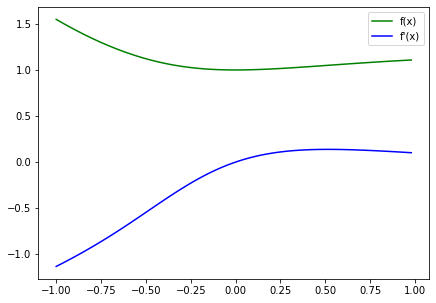

In [24]:
# Création d'un tableau NumPy à valeurs dans [-1,1]
v=np.arange(-1,1,0.02) 

# Création du tenseur PyTorch correspondant
x=torch.tensor(v,requires_grad = True)
# Création du tenseur contenant les f(x_i) où x_i est un coefficient de x 
# NB: On pourrait différencier f par rapport à n'importe quelle
# variable ci-dessous
y=x**2
z=torch.exp(-x)
w=1+y*z
f = w**(1/3)

# Appel de backward sur f (Rappel : f est un tenseur et non un scalaire)
f.backward(torch.ones(x.shape))
print(x.grad)

# Affichage de f et x.grad
# Pour les afficher comme des tableaux NumPy, il est nécessaire 
# d'utiliser la commande detach().
plt.figure(figsize=(7, 5))
plt.plot(v,f.detach().numpy(),'g',label='f(x)')
plt.plot(v,x.grad.detach().numpy(),'b',label="f'(x) autodiff")
plt.legend()
plt.show()

In [ ]:
# Version 2.0 - C. W. Royer, octobre 2023.